## Dev

In [56]:
%pip install -qU langchain-community langgraph langgraph-checkpoint-sqlite langchain-openai langchain-groq langchain_mistralai

Note: you may need to restart the kernel to use updated packages.


### LangGraph

In [127]:
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_milvus import Milvus
from pymilvus.model.hybrid import BGEM3EmbeddingFunction
from langchain.embeddings.base import Embeddings

import sys
sys.path.insert(1, '../DefAgent/src')

import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import prompts as prompts
import utils as utils
import tools as modelTools

In [4]:
from langchain_openai import ChatOpenAI

gpt = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.environ['OPENAI_API_KEY'])

from langchain_groq import ChatGroq

groq = ChatGroq(model="llama3-8b-8192")

from langchain_mistralai import ChatMistralAI

mix = ChatMistralAI(model="open-mistral-nemo", api_key=os.environ['MISTRAL_API_KEY'])

gemma = ChatOllama(model="gemma2:2b")

llama32 = ChatOllama(model='llama3.2')

In [5]:
#retriever testing
retriever = utils.setup_vectorstore()
docs = retriever.invoke("dog")
docs

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

[Document(metadata={'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'id': 454083167390558719, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785318, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32013R0576.xml', 'id': 454083165158128105, 'references': []}, page_content='documentary check: means verification of the identification document accompanying the pet animal;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32016R0429.xml', 'id': 454083166252585385, 'references': []}, page_content='animals: means vertebrate and invertebrate animals;'),
 Document(metadata={'dataset': 'PDL', 'document_id': '18PDL0002590_PD.xml', 'id': 454083162477953132, 'references': []}, page_content='animale da pelliccia: le seguenti specie di animali: cane procion

In [ ]:
from typing import Annotated, Literal, Sequence, List, Any, Dict
from typing_extensions import TypedDict
from pprint import pprint

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.callbacks.base import BaseCallbackHandler

from pydantic import BaseModel, Field


class CustomHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        formatted_prompts = "\n".join(prompts)
        print(f"-> PROMPT:\n{formatted_prompts}\n")


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    input_query: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


class DefAgent:
    def __init__(self, model):
        self.model = model
        #self.retriever_tool = modelTools.retriever_tool()
        self.retriever_tool = modelTools.retriever()
        self.tools = [self.retriever_tool]
        self.workflow = self.setup_workflow()

    def agent(self, state):
        """
        Invokes the agent model to generate a response based on the current state. Given
        the question, it will decide to retrieve using the retriever tool, or simply end.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        print("---QURY AGENT---")
        model = self.model.bind_tools(self.tools)
        input_query = state["input_query"]
        messages = state["messages"]
        response = model.invoke(messages, config={"callbacks": [CustomHandler()]})
        # We return a list, because this will get added to the existing list
        return {"messages": [response], "input_query": input_query}
    

    def filter_definitions(self, state) -> Literal["generate"]:
        """
        Filters the retrieved definitions based on their relevance to the question.

        Args:
            state (messages): The current state

        Returns:
            List[dict]: A list of dictionaries containing the relevant definitions and their metadata.
        """

        print("---FILTER DEFINITIONS---")

        class DefinitionMetadata(BaseModel):
            id: int = Field(description="the unique identifier of the definition")
            dataset: str = Field(description="the dataset the definition is from")
            document_id: str = Field(description="the document id the definition is from")
            references: List[str] = Field(description="the references mentioned the definition.")

        class Definition(BaseModel):
            metadata: DefinitionMetadata
            definition_text: str = Field(description="the full text of the definition")  # Changed from 'definition'

        class DefinitionsList(BaseModel):
            relevant_definitions: List[Definition] = Field(description="a list of relevant definitions")

        # Set up a parser + inject instructions into the prompt template.
        parser = PydanticOutputParser(pydantic_object=DefinitionsList)

        # Prompt
        prompt = PromptTemplate(
            template="""
            You are a legal expert assessing the relevance of legal definitions to a user question. \n 
            Your job is to filter the list of definitions provided to you keeping only the relevant ones. \n
            If the definition contains keyword(s) or semantic meaning related to the user's question, keep it.\n
            Output only the relevant definitions using the formatting instructions provided. \n
            Here are the formatting instructions: {format_instructions} \n
            Here are the retrieved definitions, one for each line: \n {context} \n
            Here is the user question: {question} \n
            """,
            input_variables=["context", "question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        def format_docs(docs):
            return "\nxXx".join(doc.page_content for doc in docs)


        # Chain
        chain = prompt | self.model

        messages = state["messages"]
        last_message = messages[-1]

        question = state["input_query"]
        docs = last_message.content

        response = chain.invoke({"question": question, "context": docs}, config={"callbacks": [CustomHandler()]})

        return {"messages": [response]}



    def generate(self, state):
        """
        Generate definition

        Args:
            state (messages): The current state

        Returns:
            str: A legal definition
        """
        print("---GENERATE---")
        messages = state["messages"]
        question = state["input_query"]
        last_message = messages[-1]

        docs = last_message.content

        # Prompt
        prompt = PromptTemplate(
            template="""
            You are a legal assistant for the task of generating legal definitions. \n
            Use the following retrieved definitions as context to answer the question. \n
            If you don't know the answer, just say that you don't know. \n
            Keep the answer concise and straight to the point, giving only the definition.
            Question: {question} \n
            Context: {context} \n
            Answer:
            """,
            input_variables=["context", "question"]
        )

        # LLM
        llm = self.model

        # Post-processing
        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        # Chain
        rag_chain = prompt | llm | StrOutputParser()

        # Run
        response = rag_chain.invoke({"context": docs, "question": question}, config={"callbacks": [CustomHandler()]})
        return {"messages": [response]}
    

    def eurlex_agent(self, state):
        raise NotImplementedError

    def normattiva_agent(self, state):
        raise NotImplementedError

    def pdl_agent(self, state):
        raise NotImplementedError

    def setup_workflow(self):
        # Define a new graph
        workflow = StateGraph(AgentState)

        # Define the nodes we will cycle between
        workflow.add_node("agent", self.agent)  # agent
        workflow.add_node("retrieve", ToolNode([self.retriever_tool]))  # retrieval
        workflow.add_node("filter", self.filter_definitions)  # retrieval
        workflow.add_node("generate", self.generate)  # Generating a response after we know the documents are relevant
        #workflow.add_node("RefResolver", self.resolve_references)
        #workflow.add_node("EurLex agent", self.eurlex_agent)
        #workflow.add_node("Normattiva agent", self.normattiva_agent)
        #workflow.add_node("PDL agent", self.pdl_agent)


        # Define the edges between the nodes
        # Call agent node to decide to retrieve or not
        workflow.add_edge(START, "agent")

        # Decide whether to retrieve
        workflow.add_conditional_edges(
            "agent",
            # Assess agent decision
            tools_condition,
            {
                # Translate the condition outputs to nodes in our graph
                "tools": "retrieve",
                END: END,
            },
        )

        # Edges taken after the `action` node is called.
        workflow.add_edge("retrieve", "filter")
        #workflow.add_edge("filter", "RefResolver")
        workflow.add_edge("filter", "generate")
        #workflow.add_edge("generate", "EurLex agent")
        #workflow.add_edge("generate", "Normattiva agent")
        #workflow.add_edge("generate", "PDL agent")
        #workflow.add_edge("EurLex agent", END)
        #workflow.add_edge("Normattiva agent", END)
        #workflow.add_edge("PDL agent", END)
        workflow.add_edge("generate", END)

        # Compile
        self.graph = workflow.compile()

        return workflow
    
    def invoke(self, query):
        inputs = {
            "input_query": query,
            "messages": [
                ("system", ''),
                ("user", query),
            ]
        }

        for output in self.graph.stream(inputs):
            for key, value in output.items():
                print(f"<- OUTPUT from node '{key}':\n")
                print(value['messages'][-1])#, indent=2, width=80, depth=None)
            print("\n---\n")

model = groq
defagent = DefAgent(model)

AttributeError: module 'tools' has no attribute 'retriever'

---

## Use

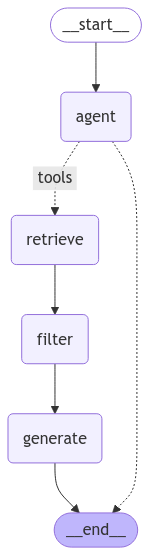

In [43]:
graph = defagent.graph

utils.draw_graph(graph)

In [19]:
vectorstore.invoke('gatto')

[Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785318, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'id': 454083167390558719, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785320, 'references': []}, page_content='ferret: means a kept animal of the Mustela putorius furo species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'id': 454083167390558721, 'references': []}, page_content='ferret: means a kept animal of the Mustela putorius furo species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785319, 'references': []}, page_content='cat: means a kept animal of the Felis silvestris species;')]

In [112]:
defagent.model = groq

defagent.invoke('Quale è la definizione di gatto?')

---QURY AGENT---
-> PROMPT:
System: 
Human: Quale è la definizione di gatto?

<- OUTPUT from node 'agent':

content='' additional_kwargs={'tool_calls': [{'id': 'call_5pk9', 'function': {'arguments': '{"query":"gatto"}', 'name': 'retrieve_definitions'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 931, 'total_tokens': 998, 'completion_time': 0.055833333, 'prompt_time': 0.167532192, 'queue_time': 0.0014390370000000041, 'total_time': 0.223365525}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6b4ffd10-e3bc-44f3-9705-8f0108e478d5-0' tool_calls=[{'name': 'retrieve_definitions', 'args': {'query': 'gatto'}, 'id': 'call_5pk9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 931, 'output_tokens': 67, 'total_tokens': 998}

---

<- OUTPUT from node 'retrieve':

content='dog: means a kept animal of the Canis lupus species;\n\ndog: means a kept animal of the 

---

In [98]:
modelTools.retriever_tool().invoke('gatto')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

'dog: means a kept animal of the Canis lupus species;\n\ndog: means a kept animal of the Canis lupus species;\n\nferret: means a kept animal of the Mustela putorius furo species;\n\nferret: means a kept animal of the Mustela putorius furo species;\n\ncat: means a kept animal of the Felis silvestris species;\n\ncat: means a kept animal of the Felis silvestris species;\n\npet animal: means an animal of a species listed in Annex I accompanying its owner or an authorised person during non-commercial movement, and which remains for the duration of such non-commercial movement under the responsibility of the owner or the authorised person;\n\npet animal: means pet animal as defined in point (11) of Article 4 of Regulation (EU) 2016/429 of the European Parliament and of the Council Regulation (EU) 2016/429 of the European Parliament and of the Council of 9 March 2016 on transmissible animal diseases and amending and repealing certain acts in the area of animal health ( "Animal Health Law) ( O

In [93]:
modelTools.vector_search('gatto')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

[Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785318, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'id': 454083167390558719, 'references': []}, page_content='dog: means a kept animal of the Canis lupus species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785320, 'references': []}, page_content='ferret: means a kept animal of the Mustela putorius furo species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'id': 454083167390558721, 'references': []}, page_content='ferret: means a kept animal of the Mustela putorius furo species;'),
 Document(metadata={'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'id': 454083167481785319, 'references': []}, page_content='cat: means a kept animal of the Felis silvestris species;'),
 Document(metadata={'dat

In [94]:
modelTools.multiply(2, 3)

6